In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 
import pickle

import astrobf
from astrobf.utils import mask_utils
from astrobf.utils.mask_utils import *
from astrobf.utils import gen_mask
#from astrobf import measure_morph

#import statmorph

In [20]:
# All data
all_gals = pickle.load(open("../../bf_data/Nair_and_Abraham_2010/all_gals.pickle", "rb"))

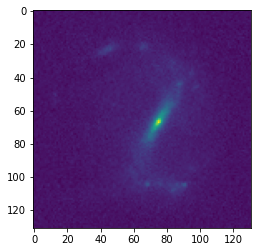

In [21]:
test = all_gals[3]

test['data'].shape

plt.imshow(test['data'][0])
plt.show()

## TMO

In [76]:
def Mantiuk_Seidel(lum, b, c, dl, dh):
    al = (c*dl-1)/dl # contrast compression for shadows
    ah = (c*dh-1)/dh
    lp = np.log10(lum) # L prime
    
    print("{:.5f} {:.5f} {:.5f} {:.5f}".format(b-dl, b+dh, al, ah))

    conditions=[lp <= b-dl,
                (b-dl < lp) * (lp <= b),
                (b < lp) * (lp <= b+dh),
                lp > b+dh]

    functions=[0,
               lambda lp : 1/2*c*(lp-b)/(1-al*(lp-b))+1/2,
               lambda lp : 1/2*c*(lp-b)/(1+ah*(lp-b))+1/2,
               1]

    return np.piecewise(lp, conditions, functions)

Condition:

* b - dl < max(lp)  
* b + dh > min(lp)


-1.00000 4.00000 4.80000 4.80000


<ipython-input-76-a43e52823e00>:4: RuntimeWarning: divide by zero encountered in log10
  lp = np.log10(lum) # L prime


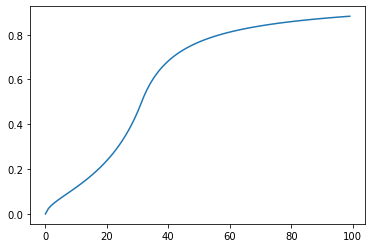

In [89]:
tmo_params = {'b': 1.5, 'c': 5.2, 'dl': 2.5, 'dh': 2.5}
plt.plot(Mantiuk_Seidel(np.linspace(0,100,100), **tmo_params))

**Mantiuk08 condition:**  

b < dl  
NO constraint between dh and dl!

conditions=[lp <= b-dl,
            (b-dl < lp) * (lp <= b),
            (b < lp) * (lp <= b+dh),
            lp > b+dh]

<ipython-input-22-ef84b1df7157>:4: RuntimeWarning: invalid value encountered in log10
  lp = np.log10(lum) # L prime
<ipython-input-22-ef84b1df7157>:6: RuntimeWarning: invalid value encountered in less_equal
  conditions=[lp <= b-dl,
<ipython-input-22-ef84b1df7157>:7: RuntimeWarning: invalid value encountered in greater
  (b-dl < lp) * (lp <= b),
<ipython-input-22-ef84b1df7157>:7: RuntimeWarning: invalid value encountered in less_equal
  (b-dl < lp) * (lp <= b),
<ipython-input-22-ef84b1df7157>:8: RuntimeWarning: invalid value encountered in greater
  (b < lp) * (lp <= b+dh),
<ipython-input-22-ef84b1df7157>:8: RuntimeWarning: invalid value encountered in less_equal
  (b < lp) * (lp <= b+dh),
<ipython-input-22-ef84b1df7157>:9: RuntimeWarning: invalid value encountered in greater
  lp > b+dh]
<ipython-input-42-5b63c56bbf9d>:10: RuntimeWarning: invalid value encountered in log10
  axs[0].imshow(np.log10(img))


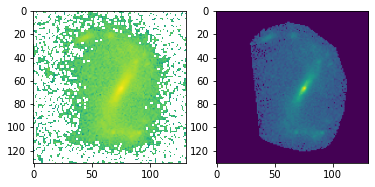

In [42]:
tmo_params = {'b': 1., 'c': 23.0, 'dl': 10.2833053525731244, 'dh': 1002.949584662550268}

img, mask, weight = test['data']
masked = img.copy()
masked[~mask.astype(bool)] = np.nan

tonemapped = Mantiuk_Seidel(masked, **tmo_params)

fig, axs = plt.subplots(1,2)
axs[0].imshow(np.log10(img))
axs[1].imshow(tonemapped)
plt.show()
#morph = statmorph.source_morphology(tonemapped, mask, weightmap=weight, sersic_maxiter=0)[0]
#image_diagnostics.make_figure(morph, nrows=3,
#                                savefig=f"stat_morph_diagnostics_{i}.png", img_org=None)


In [44]:
tonemapped.max()

0.026471823

In [2]:
import torch
import math

# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

ModuleNotFoundError: No module named 'torch'

### Initial guesses 


In [3]:
fields = ['r20', 'r80',
          'gini', 'm20', 'concentration', 'asymmetry', 'smoothness']

def select_columns(arr, fields):
    dtype = np.dtype([(name, arr.dtype.fields[name][0]) for name in fields])
    newarr = np.zeros(arr.shape, dtype=dtype)
    for name in dtype.names:
        newarr[name] = arr[name]
    return newarr

def struct_to_ndarray(strarr):
    """
    Takes 'contiguous' structured array. Doesn't work with discontinuous views!
    
    """
    return strarr.view(np.float64).reshape(strarr.shape + (-1,))

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, Birch, DBSCAN, MeanShift, SpectralClustering
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
def bench_clustering(clu, data, labels):
    """Benchmark to evaluate the clu initialization methods.

    Parameters
    ----------
    clu : clu instance
        A :class:`~sklearn.cluster.A_clustering_method` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """

    #t0 = time()
    estimator = make_pipeline(StandardScaler(), clu).fit(data)
    #fit_time = time() - t0
    results = [estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(data, estimator[-1].labels_,
                                 metric="euclidean", sample_size=300,)
    ]

    return results

In [8]:
def measure_morph(tmo_params):
    ngal = len(all_gals)
    result_arr = np.zeros(ngal, 
                          dtype=[('id','<U24'),('ttype',int),('flag',bool),('flag_sersic',bool)]
                                   +[(ff,float) for ff in fields])
    for i, gal in enumerate(all_gals):
        img, mask, weight = gal['data']
        masked = img.copy()
        masked[~mask.astype(bool)] = np.nan
        
        tonemapped = Mantiuk_Seidel(masked, **tmo_params)
        #print("total fulx", np.sum(tonemapped))
        if np.sum(tonemapped) <= 0:
            return ['bad', np.sum(tonemapped)]
        #logging.info('subtrated min max: {}, {} --  tonemapped min max: {},{}'.format(subtracted.min(), subtracted.max(), tonemapped.min(), tonemapped.max()))
        morph = statmorph.source_morphology(tonemapped, mask, weightmap=weight, sersic_maxiter=0)[0]

        # get all measurements
        result_arr[i]['id'] = gal['img_name']
        for ff in fields:
            result_arr[i][ff] = getattr(morph, ff)
    return result_arr

def add_ttype(result_arr, cat):
    inds = cat['ID'].searchsorted(result_arr['id'])
    print("Is every element matched?: ", np.all(cat[inds]['ID'] == result_arr['id']))
    result_arr['ttype'] = cat[inds]['TT']

def do_ML(result_arr, n_clusters=2):
    compact = struct_to_ndarray(select_columns(result_arr, ['gini', 'm20', 'concentration']))
    
    # Binary classification 
    labels = np.zeros(len(result_arr), dtype=np.int8)
    ind_positive = np.where((result_arr['ttype'] > 3) * (result_arr['ttype'] < 6))[0]
    print("positive samples {}/{}".format(len(ind_positive), len(result_arr)))
    labels[ind_positive] = 1 # Zero otherwise

    clustering = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4,
                    random_state=0)
    
    eval_metrics = bench_clustering(clustering, compact, labels)
    return eval_metrics

# Run Bayesian Optimization loop

In [14]:
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.ax_client import AxClient
#from ax.utils.notebook.plotting import render, init_notebook_plotting
#init_notebook_plotting()

### define evaluation function
1. Measure Morphological parameters 
2. cluster/classify 
3. assess clustering/classification


In [5]:
from astrobf.utils.misc import load_Nair
cat = load_Nair('../../bf_data/Nair_and_Abraham_2010/catalog/table2.dat')
all_gals = pickle.load(open("all_gals.pickle", "rb"))

all_gals = all_gals[:10]

                         ID      RA    dec  zred  zred_q     mg     mr  Mag_r  \
0      J155341.74-003422.84  238.42  -0.57  0.07    1.00  15.82  15.05 -22.08   
1      J155146.83-000618.62  237.94  -0.10  0.05    1.00  15.51  14.60 -21.56   
2      J154453.22+002415.48  236.22   0.40  0.03    1.00  15.63  14.83 -20.27   
3      J154711.32+002424.81  236.79   0.40  0.03    0.96  15.71  15.15 -20.10   
4      J154514.39+004619.89  236.31   0.77  0.01    1.00  15.34  14.95 -18.38   
...                     ...     ...    ...   ...     ...    ...    ...    ...   
14029  J124719.07+154235.64  191.83  15.71  0.06    1.00  15.78  14.90 -21.85   
14030  J130510.16+152606.67  196.29  15.43  0.05    1.00  15.31  14.59 -21.62   
14031  J131525.21+152522.23  198.85  15.42  0.02    1.00  15.25  14.34 -20.14   
14032  J132045.57+151532.75  200.19  15.26  0.02    0.99  15.72  14.93 -19.32   
14033  J132135.96+151917.80  200.40  15.32  0.02    1.00  15.47  14.80 -19.47   

       logLg  Rpetro   Rp50

In [14]:
from statmorph.utils import image_diagnostics

In [19]:
#tmo_params = {'b':1.68,'c':0.53,'dl':4.12,'dh':2.46}
tom_params = {'b': 2.0, 'c': 3.0, 'dl': 2.2833053525731244, 'dh': 2.949584662550268}

ngal = len(all_gals)
result_arr = np.zeros(ngal, 
                      dtype=[('id','<U24'),('ttype',int),
                             ('flag',bool),('flag_sersic',bool)]
                               +[(ff,float) for ff in fields])

for i, gal in enumerate(all_gals):
    img, mask, weight = gal['data']
    masked = img.copy()
    masked[~mask.astype(bool)] = np.nan

    tonemapped = Mantiuk_Seidel(masked, **tmo_params)
    morph = statmorph.source_morphology(tonemapped, mask, weightmap=weight, sersic_maxiter=0)[0]
    image_diagnostics.make_figure(morph, nrows=3,
                                    savefig=f"stat_morph_diagnostics_{i}.png", img_org=None)
    # get all measurements
    result_arr[i]['id'] = gal['img_name']
    for ff in fields:
        result_arr[i][ff] = getattr(morph, ff)

<ipython-input-4-ef84b1df7157>:4: RuntimeWarning: invalid value encountered in log10
  lp = np.log10(lum) # L prime
<ipython-input-4-ef84b1df7157>:4: RuntimeWarning: invalid value encountered in log10
  lp = np.log10(lum) # L prime
<ipython-input-4-ef84b1df7157>:4: RuntimeWarning: invalid value encountered in log10
  lp = np.log10(lum) # L prime
<ipython-input-4-ef84b1df7157>:4: RuntimeWarning: invalid value encountered in log10
  lp = np.log10(lum) # L prime
<ipython-input-4-ef84b1df7157>:4: RuntimeWarning: invalid value encountered in log10
  lp = np.log10(lum) # L prime
<ipython-input-4-ef84b1df7157>:4: RuntimeWarning: invalid value encountered in log10
  lp = np.log10(lum) # L prime
<ipython-input-4-ef84b1df7157>:4: RuntimeWarning: invalid value encountered in log10
  lp = np.log10(lum) # L prime
<ipython-input-4-ef84b1df7157>:4: RuntimeWarning: invalid value encountered in log10
  lp = np.log10(lum) # L prime
<ipython-input-4-ef84b1df7157>:4: RuntimeWarning: invalid value encounte

In [52]:
def evaluate(params):
    result_arr = measure_morph(params)
    if result_arr[0] == "bad":
        print(result_arr)
        return {"mymetric": (-1, 0), "total_flux":(result_arr[1],0)}
    add_ttype(result_arr, cat)
    eval_metrics = do_ML(result_arr)
    silhouette_score = eval_metrics[-1]
    stderr = 0.0
    return {"mymetric": (silhouette_score, stderr), "total_flux":(1,0)}

**Mantiuk08 condition:**  

b > dl  
NO constraint between dh and dl!

conditions=[lp <= b-dl,
            (b-dl < lp) * (lp <= b),
            (b < lp) * (lp <= b+dh),
            lp > b+dh]

In [53]:
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [54]:
ax_client = AxClient()

[INFO 03-18 04:39:48] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.


In [55]:
ax_client.create_experiment(
    parameters=[
        {
            "name": "b",
            "type": "range",
            "bounds": [1.0, 3.0],
            "value_type": "float",  # Optional, defaults to inference from type of "bounds".
            "log_scale": False,  # Optional, defaults to False.
        },
        {
            "name": "c",
            "type": "range",
            "bounds": [0.5, 5.0],
        },
        {
            "name": "dl",
            "type": "range",
            "bounds": [0.5, 4.0],
        },
        {
            "name": "dh",
            "type": "range",
            "bounds": [0.5, 7.0],
        },
    ],
    objective_name="mymetric",
    #minimize=True,  # Optional, defaults to False. Maximize Shiloutte score
    #parameter_constraints=["b >= dl"],  # Optional.
    overwrite_existing_experiment =True,
    outcome_constraints=["total_flux >= 1e-5"],  # Optional.
)

[INFO 03-18 04:40:15] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter c. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-18 04:40:15] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter dl. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-18 04:40:15] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter dh. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-18 04:40:15] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-f

In [56]:
for i in range(50):
    parameters, trial_index = ax_client.get_next_trial()
    
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))


[INFO 03-18 04:40:19] ax.service.ax_client: Generated new trial 0 with parameters {'b': 1.54, 'c': 0.62, 'dl': 2.64, 'dh': 2.02}.
[INFO 03-18 04:43:30] ax.service.ax_client: Completed trial 0 with data: {'mymetric': (-1, 0), 'total_flux': (0.0, 0)}.
[INFO 03-18 04:43:30] ax.service.ax_client: Generated new trial 1 with parameters {'b': 1.7, 'c': 0.65, 'dl': 0.82, 'dh': 2.79}.
[INFO 03-18 04:43:30] ax.service.ax_client: Completed trial 1 with data: {'mymetric': (-1, 0), 'total_flux': (0.0, 0)}.
[INFO 03-18 04:43:30] ax.service.ax_client: Generated new trial 2 with parameters {'b': 1.45, 'c': 4.05, 'dl': 2.68, 'dh': 1.95}.


['bad', 0.0]
['bad', 0.0]


<ipython-input-52-5408cdd43429>:3: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 03-18 04:47:52] ax.service.ax_client: Completed trial 2 with data: {'mymetric': (1.0, 0.0), 'total_flux': (1, 0)}.
[INFO 03-18 04:47:52] ax.service.ax_client: Generated new trial 3 with parameters {'b': 1.63, 'c': 2.44, 'dl': 0.57, 'dh': 3.82}.
[INFO 03-18 04:47:52] ax.service.ax_client: Completed trial 3 with data: {'mymetric': (-1, 0), 'total_flux': (0.0, 0)}.
[INFO 03-18 04:47:52] ax.service.ax_client: Generated new trial 4 with parameters {'b': 2.35, 'c': 1.09, 'dl': 2.5, 'dh': 5.68}.


Is every element matched?:  True
positive samples 204/1000
['bad', 0.0]


[INFO 03-18 04:47:52] ax.service.ax_client: Completed trial 4 with data: {'mymetric': (-1, 0), 'total_flux': (0.0, 0)}.


['bad', 0.0]


[INFO 03-18 04:47:53] ax.service.ax_client: Generated new trial 5 with parameters {'b': 1.39, 'c': 4.68, 'dl': 2.97, 'dh': 1.59}.
<ipython-input-52-5408cdd43429>:3: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 03-18 04:52:42] ax.service.ax_client: Completed trial 5 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.


Is every element matched?:  True
positive samples 204/1000


[INFO 03-18 04:52:43] ax.service.ax_client: Generated new trial 6 with parameters {'b': 1.75, 'c': 4.08, 'dl': 2.57, 'dh': 1.6}.
[INFO 03-18 04:56:11] ax.service.ax_client: Completed trial 6 with data: {'mymetric': (-1, 0), 'total_flux': (0.0, 0)}.


['bad', 0.0]


[INFO 03-18 04:56:12] ax.service.ax_client: Generated new trial 7 with parameters {'b': 1.36, 'c': 3.88, 'dl': 2.57, 'dh': 2.32}.


Is every element matched?:  True
positive samples 204/1000


<ipython-input-52-5408cdd43429>:3: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [49]:
best_parameters, values = ax_client.get_best_parameters()

In [50]:
best_parameters

{'b': 2.0, 'c': 3.0, 'dl': 2.2833053525731244, 'dh': 2.949584662550268}